# :basketball: 3 - Train augmentation datasets

## Imports

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
from ultralytics import YOLO

In [12]:
import torch
print(torch.cuda.is_available())

True


In [13]:
import warnings
warnings.filterwarnings("ignore")

## Predefined variables

In [ ]:
YAML_GEOMETRIC_PATH = "../data/basketball.yolov8-augmented/geometric/data.yaml"
YAML_COLOR_PATH = "../data/basketball.yolov8-augmented/color/data.yaml"
YAML_KERNEL_PATH = "../data/basketball.yolov8-augmented/kernel/data.yaml"
RESULTS_DIR = "../results/"
MEDIA_DIR = "../media/"

AUG_YAML_PATHS = {
    "geometric": YAML_GEOMETRIC_PATH,
    "color": YAML_COLOR_PATH,
    "kernel": YAML_KERNEL_PATH
}

PROJECT_ROOT = Path.cwd().parent
RUNS_DIR = PROJECT_ROOT / "runs" / "augmented"

Path(RUNS_DIR).mkdir(parents=True, exist_ok=True)

EPOCHS = 100
IMG_SIZE = 640
BATCH_SIZE = 16

## Train augmented datasets

In [ ]:
# Function to train and evaluate the model
def train_and_evaluate(dataset_name, yaml_path):
    print(f"Training YOLOv8n on {dataset_name} augmented dataset...")

    # Clear CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Define run names
    train_name = f"yolov8n-{dataset_name}-train"
    valid_name = f"yolov8n-{dataset_name}-valid"

    # Load YOLOV8n model
    yolov8 = YOLO("yolov8n.pt", "detect").to('cuda' if torch.cuda.is_available() else 'cpu')

    # Train the model
    yolov8.train(
        data=yaml_path,
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        project=str(RUNS_DIR),
        name=train_name,
        augment=False,
        exist_ok=False,
        workers=0 # Set workers to 0 for compatibility and reduce overhead
    )

    # Clear CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Evaluate the model on test set
    metrics = yolov8.val(data=yaml_path, project=str(RUNS_DIR), name=valid_name, split="test", exist_ok=False)
    print(f"Evaluation metrics for {dataset_name} augmented dataset: {metrics}")

    # Clear CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Return the evaluation metrics for further use
    return metrics

In [16]:
# Train and evaluate on all augmented datasets and store metrics
all_metrics = {}

for dataset_name, yaml_path in AUG_YAML_PATHS.items():
    metrics = train_and_evaluate(dataset_name, yaml_path)
    all_metrics[dataset_name] = metrics

Training YOLOv8n on geometric augmented dataset...
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/basketball.yolov8-augmented/geometric/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n-geometric-train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

## Visualize metrics

In [28]:
# Export results to a DataFrame for better visualization
rows = []

for dataset_name, metrics in all_metrics.items():
    results = metrics.results_dict

    rows.append({
        "Dataset": dataset_name,
        "mAP50": results['metrics/mAP50(B)'],
        "mAP50-95": results['metrics/mAP50-95(B)'],
        "Precision": results['metrics/precision(B)'],
        "Recall": results['metrics/recall(B)']
    })

metrics_df = pd.DataFrame(rows)
metrics_df

,Dataset,mAP50,mAP50-95,Precision,Recall
0,geometric,0.830958,0.507676,0.842009,0.784184
1,color,0.827571,0.524035,0.901517,0.771817
2,kernel,0.828368,0.513148,0.862843,0.786140


In [29]:
# Save the metrics to a CSV file
metrics_df.to_csv(RESULTS_DIR + "augmentation_metrics.csv", index=False)

In [52]:
# Reread the CSV file and plot the results
metrics_df = pd.read_csv(RESULTS_DIR + "augmentation_metrics.csv") # uncomment this line if running this cell separately

### Plots

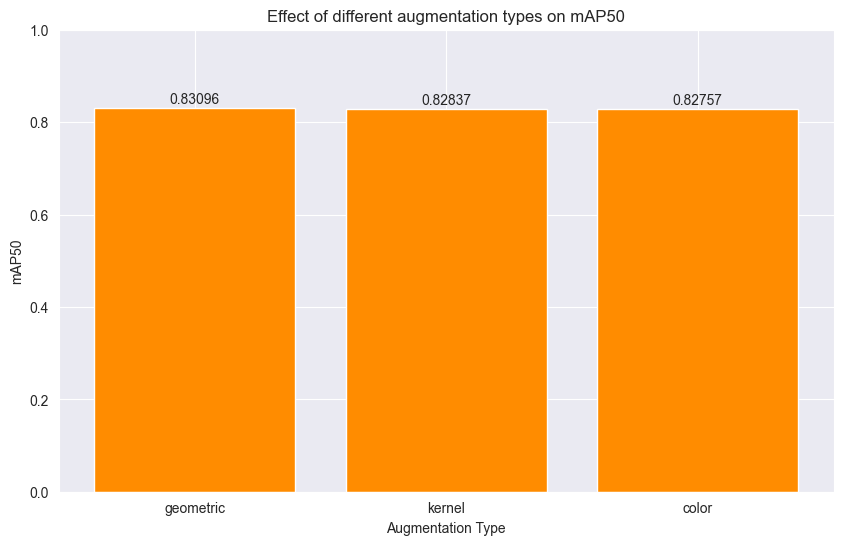

In [53]:
# Plot mAP50 for each augmentation type
sns.set_style("darkgrid")

metrics_df_sorted = metrics_df.sort_values(by="mAP50", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(metrics_df_sorted['Dataset'], metrics_df_sorted['mAP50'], color="darkorange")
for i, v in enumerate(metrics_df_sorted['mAP50']):
    plt.text(i, v + 0.01, f"{v:.5f}", ha='center')
plt.title('Effect of different augmentation types on mAP50')
plt.xlabel('Augmentation Type')
plt.ylabel('mAP50')
plt.ylim(0, 1)
plt.show()

# Save this figure to media directory
plt.figure(figsize=(10, 6))
plt.bar(metrics_df_sorted['Dataset'], metrics_df_sorted['mAP50'], color="darkorange")
for i, v in enumerate(metrics_df_sorted['mAP50']):
    plt.text(i, v + 0.01, f"{v:.5f}", ha='center')
plt.title('Effect of different augmentation types on mAP50')
plt.xlabel('Augmentation Type')
plt.ylabel('mAP50')
plt.ylim(0, 1)
plt.savefig(f"{MEDIA_DIR}03-augmentations-mAP50.png")
plt.close()

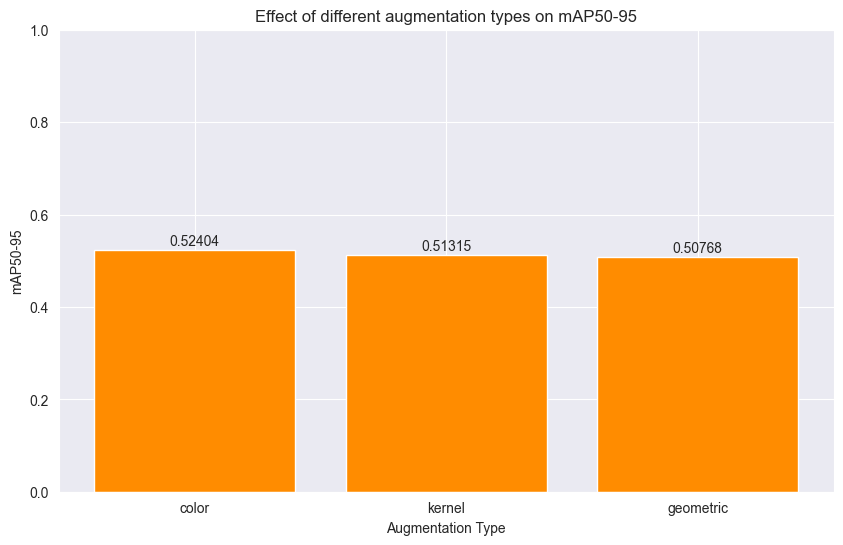

In [54]:
# Plot mAP50-95 for each augmentation type
sns.set_style("darkgrid")

metrics_df_sorted = metrics_df.sort_values(by="mAP50-95", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(metrics_df_sorted['Dataset'], metrics_df_sorted['mAP50-95'], color="darkorange")
for i, v in enumerate(metrics_df_sorted['mAP50-95']):
    plt.text(i, v + 0.01, f"{v:.5f}", ha='center')
plt.title('Effect of different augmentation types on mAP50-95')
plt.xlabel('Augmentation Type')
plt.ylabel('mAP50-95')
plt.ylim(0, 1)
plt.show()

# Save this figure to media directory
plt.figure(figsize=(10, 6))
plt.bar(metrics_df_sorted['Dataset'], metrics_df_sorted['mAP50-95'], color="darkorange")
for i, v in enumerate(metrics_df_sorted['mAP50-95']):
    plt.text(i, v + 0.01, f"{v:.5f}", ha='center')
plt.title('Effect of different augmentation types on mAP50-95')
plt.xlabel('Augmentation Type')
plt.ylabel('mAP50-95')
plt.ylim(0, 1)
plt.savefig(f"{MEDIA_DIR}03-augmentations-mAP50-95.png")
plt.close()

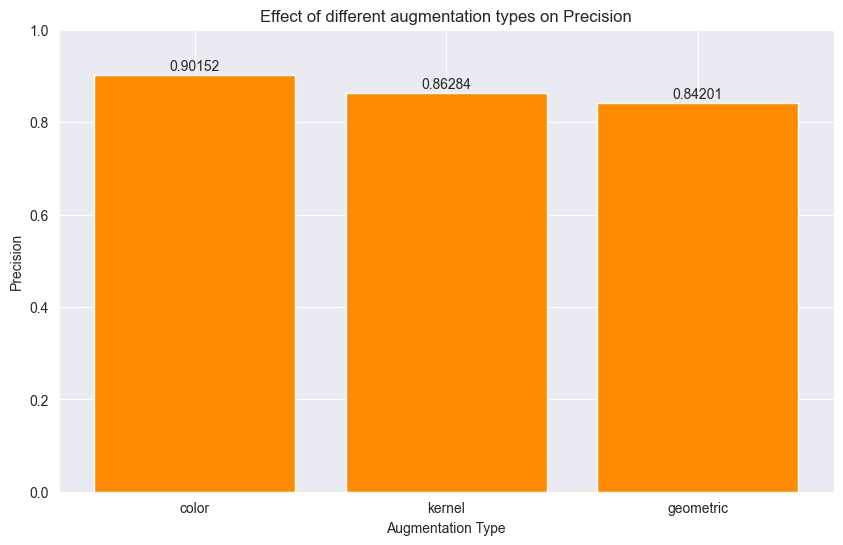

In [55]:
# Plot Precision for each augmentation type
sns.set_style("darkgrid")

metrics_df_sorted = metrics_df.sort_values(by="Precision", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(metrics_df_sorted['Dataset'], metrics_df_sorted['Precision'], color="darkorange")
for i, v in enumerate(metrics_df_sorted['Precision']):
    plt.text(i, v + 0.01, f"{v:.5f}", ha='center')
plt.title('Effect of different augmentation types on Precision')
plt.xlabel('Augmentation Type')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.show()

# Save this figure to media directory
plt.figure(figsize=(10, 6))
plt.bar(metrics_df_sorted['Dataset'], metrics_df_sorted['Precision'], color="darkorange")
for i, v in enumerate(metrics_df_sorted['Precision']):
    plt.text(i, v + 0.01, f"{v:.5f}", ha='center')
plt.title('Effect of different augmentation types on Precision')
plt.xlabel('Augmentation Type')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.savefig(f"{MEDIA_DIR}03-augmentations-Precision.png")
plt.close()

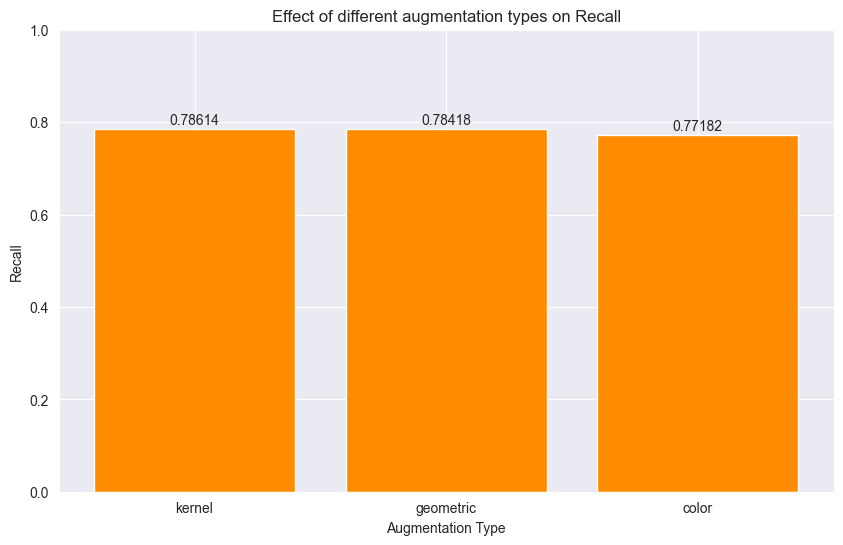

In [56]:
# Plot Recall for each augmentation type
sns.set_style("darkgrid")

metrics_df_sorted = metrics_df.sort_values(by="Recall", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(metrics_df_sorted['Dataset'], metrics_df_sorted['Recall'], color="darkorange")
for i, v in enumerate(metrics_df_sorted['Recall']):
    plt.text(i, v + 0.01, f"{v:.5f}", ha='center')
plt.title('Effect of different augmentation types on Recall')
plt.xlabel('Augmentation Type')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.show()

# Save this figure to media directory
plt.figure(figsize=(10, 6))
plt.bar(metrics_df_sorted['Dataset'], metrics_df_sorted['Recall'], color="darkorange")
for i, v in enumerate(metrics_df_sorted['Recall']):
    plt.text(i, v + 0.01, f"{v:.5f}", ha='center')
plt.title('Effect of different augmentation types on Recall')
plt.xlabel('Augmentation Type')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.savefig(f"{MEDIA_DIR}03-augmentations-Recall.png")
plt.close()